In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [3]:
df_train = pd.read_csv('../input/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

df_test = pd.read_csv('../input/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

df_all = pd.concat((df_train, df_test))
df_all['question1'].fillna('xzxzxz zxzxzx', inplace=True)
df_all['question2'].fillna('xzxzxz zxzxzx', inplace=True)

counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))

other_index = len(counts_vectorizer.vocabulary_)

In [4]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import keras.layers as lyr
from keras.models import Model

Using TensorFlow backend.


In [5]:
import keras
keras.__version__

'2.0.2'

In [6]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [7]:
df_all = df_all.sample(1000) # Just for debugging

In [45]:
print df_all[df_all['id'].notnull()].head()['question1'].str.split().str.len()

207632     6
335420    12
403634    24
49015      9
89918     11
Name: question1, dtype: int64


In [52]:
sorted(counts_vectorizer.vocabulary_.items(), key=lambda x: x[1])[:10]

[(u'00', 0),
 (u'000', 1),
 (u'01', 2),
 (u'04', 3),
 (u'10', 4),
 (u'100', 5),
 (u'1000', 6),
 (u'10000', 7),
 (u'1000rs', 8),
 (u'100k', 9)]

In [29]:
create_padded_seqs(df_all[df_all['id'].notnull()].head()['question1'])

array([[   0,    0,    0,    0, 9788, 4788, 5363, 4905, 8199, 3557],
       [8984, 3431, 8369, 4109, 3246, 2022, 1692, 4515, 8989, 1115],
       [1075, 5271,   33, 6356, 5887, 9788, 5746, 1075, 8984, 2103],
       [   0, 4335, 4788, 5823, 9886, 4515, 9365, 6516, 4515, 9999],
       [4788, 6800, 5838, 6171, 8416, 4515, 6518, 6306, 2552, 5921]], dtype=int32)

In [8]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=1989)

In [9]:
import tensorflow
tensorflow.__version__

'1.0.1'

In [10]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 10, 100)       1000000                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 256)           365568                                       
___________________________________________________________________________________________

In [12]:
%%time
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=128, epochs=1000, verbose=2)

Train on 86 samples, validate on 38 samples
Epoch 1/1000
0s - loss: 0.1354 - val_loss: 0.9104
Epoch 2/1000
0s - loss: 0.1335 - val_loss: 0.9173
Epoch 3/1000
0s - loss: 0.1317 - val_loss: 0.9242
Epoch 4/1000
0s - loss: 0.1301 - val_loss: 0.9311
Epoch 5/1000
0s - loss: 0.1285 - val_loss: 0.9377
Epoch 6/1000
0s - loss: 0.1270 - val_loss: 0.9441
Epoch 7/1000
0s - loss: 0.1255 - val_loss: 0.9501
Epoch 8/1000
0s - loss: 0.1242 - val_loss: 0.9557
Epoch 9/1000
0s - loss: 0.1229 - val_loss: 0.9610
Epoch 10/1000
0s - loss: 0.1217 - val_loss: 0.9660
Epoch 11/1000
0s - loss: 0.1206 - val_loss: 0.9707
Epoch 12/1000
0s - loss: 0.1194 - val_loss: 0.9754
Epoch 13/1000
0s - loss: 0.1183 - val_loss: 0.9800
Epoch 14/1000
0s - loss: 0.1172 - val_loss: 0.9844
Epoch 15/1000
0s - loss: 0.1162 - val_loss: 0.9888
Epoch 16/1000
0s - loss: 0.1152 - val_loss: 0.9930
Epoch 17/1000
0s - loss: 0.1142 - val_loss: 0.9970
Epoch 18/1000
0s - loss: 0.1132 - val_loss: 1.0009
Epoch 19/1000
0s - loss: 0.1123 - val_loss: 1.0

In [13]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [14]:
F_train = features_model.predict([X1_train, X2_train], batch_size=128)
F_val = features_model.predict([X1_val, X2_val], batch_size=128)

In [15]:
import xgboost as xgb

/home/avsolatorio/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [20]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=1000)

[0]	train-logloss:0.606833	val-logloss:0.691758
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 1000 rounds.
[10]	train-logloss:0.206232	val-logloss:0.868254
[20]	train-logloss:0.155047	val-logloss:0.943078
[30]	train-logloss:0.154219	val-logloss:0.934653
[40]	train-logloss:0.154136	val-logloss:0.932884
[50]	train-logloss:0.15408	val-logloss:0.930119
[60]	train-logloss:0.154081	val-logloss:0.929499
[70]	train-logloss:0.148045	val-logloss:0.93694
[80]	train-logloss:0.148045	val-logloss:0.937002
[90]	train-logloss:0.148045	val-logloss:0.937071
[100]	train-logloss:0.148046	val-logloss:0.937396
[110]	train-logloss:0.148045	val-logloss:0.937123
[120]	train-logloss:0.148077	val-logloss:0.934973
[130]	train-logloss:0.148046	val-logloss:0.937511
[140]	train-logloss:0.148045	val-logloss:0.937027
[150]	train-logloss:0.148071	val-logloss:0.935181
[160]	train-logloss:0.148061	val-logloss:0.935606
[170]	train-lo

In [21]:
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

In [22]:
F_test = features_model.predict([X1_test, X2_test], batch_size=128)

In [23]:
dTest = xgb.DMatrix(F_test)

In [24]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].values,
        'is_duplicate': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    }).set_index('test_id')

In [25]:
df_sub.head()

,is_duplicate
test_id,
1028428,0.543439
1805034,0.453905
1988707,0.543439
1077192,0.453905
1835446,0.453905


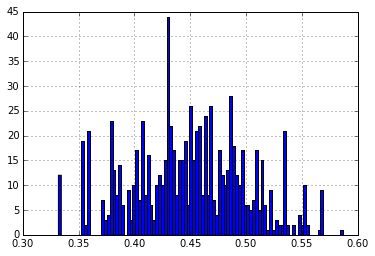

In [24]:
df_sub['is_duplicate'].hist(bins=100)

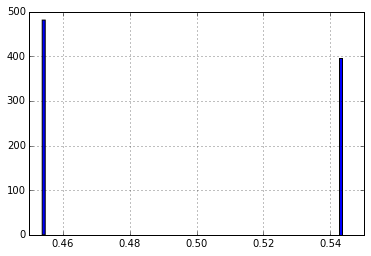

In [26]:
df_sub['is_duplicate'].hist(bins=100)

In [12]:
sub_probe = pd.DataFrame()

sub_probe['test_id'] = df_test.test_id
sub_probe['is_duplicate'] = np.ones(df_test.shape[0]) * 0.7

In [13]:
sub_probe.to_csv('sub_probe_0.7.csv', index=False)

In [ ]:
(-0.50433 - np.log(1 - p)) / (np.log(p / (1 - p)))
(nN * np.log(p / (1 - p))) + (np.log(1 - p))